# Silver Analytics – Sinistros de Trânsito (Camada SILVER)

Este notebook consulta diretamente o PostgreSQL (schema **silver**, tabela **silver_sinistros**) e gera análises exploratórias e KPIs para consumo analítico.

> Ajuste as variáveis de ambiente se necessário (host/porta/banco/usuário/senha).

In [2]:
!python -m pip install pandas numpy sqlalchemy psycopg2-binary sqlparse matplotlib

  Using cached matplotlib-3.10.8-cp314-cp314-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp314-cp314-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp314-cp314-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp314-cp314-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached matplotlib-3.10.8-cp314-cp314-win_amd64.whl (8.3 MB)
Using cached contourpy-1.3.3-cp314-cp314-win_amd64.whl (232 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp314-cp314-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp314-cp314-win_amd64.whl (75 kB)
Using cached pillow-12.1.0-cp314-cp314-win_amd64.whl (7.2 MB)
Using cached pyparsing-3.3.2-py3-none-any.whl (122 kB)

   ---------------------------------------- 0/7 [pyparsing]
   -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

# CONFIG (ajuste conforme seu ambiente)
os.environ["POSTGRES_HOST"] = os.getenv("POSTGRES_HOST", "127.0.0.1")
os.environ["POSTGRES_PORT"] = os.getenv("POSTGRES_PORT", "5433")
os.environ["POSTGRES_DB"] = os.getenv("POSTGRES_DB", "sinistros_2025")
os.environ["POSTGRES_USER"] = os.getenv("POSTGRES_USER", "postgres")
os.environ["POSTGRES_PASSWORD"] = os.getenv("POSTGRES_PASSWORD", "dan1920")

user = os.environ["POSTGRES_USER"]
pwd  = os.environ["POSTGRES_PASSWORD"]
host = os.environ["POSTGRES_HOST"]
port = os.environ["POSTGRES_PORT"]
db   = os.environ["POSTGRES_DB"]

engine = create_engine(f"postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{db}", pool_pre_ping=True)

# Teste de conexão
with engine.connect() as conn:
    conn.execute(text("SELECT 1"))
print(f"Conectado! host={host} port={port} db={db} user={user}")

Conectado! host=127.0.0.1 port=5433 db=sinistros_2025 user=postgres


## 1) Visão geral do dataset (tabela silver.silver_sinistros)

In [4]:
qry_overview = """
SELECT
  COUNT(*)::bigint AS registros,
  MIN(data_acidente) AS data_min,
  MAX(data_acidente) AS data_max,
  COALESCE(SUM(pessoas),0)::bigint AS pessoas,
  COALESCE(SUM(veiculos),0)::bigint AS veiculos,
  COALESCE(SUM(mortos),0)::bigint  AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos
FROM silver.silver_sinistros;
"""
overview = pd.read_sql(qry_overview, engine)
overview

,registros,data_min,data_max,pessoas,veiculos,mortos,feridos
0,65683,2025-01-01,2025-11-30,170009,131668,5466,75378


## 2) Sinistros por dia (série temporal)

In [5]:
qry_daily = """
SELECT
  data_acidente,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos
FROM silver.silver_sinistros
GROUP BY data_acidente
ORDER BY data_acidente;
"""
daily = pd.read_sql(qry_daily, engine)
daily.head()

,data_acidente,sinistros,mortos,feridos
0,2025-01-01,193,14,224
1,2025-01-02,161,8,243
2,2025-01-03,179,20,262
3,2025-01-04,179,15,241
4,2025-01-05,164,15,204


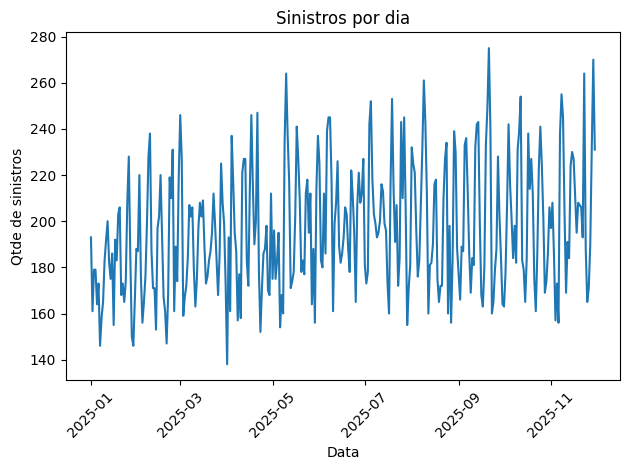

In [6]:
plt.figure()
plt.plot(daily["data_acidente"], daily["sinistros"])
plt.title("Sinistros por dia")
plt.xlabel("Data")
plt.ylabel("Qtde de sinistros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3) Top UFs (volume e severidade)

In [7]:
qry_uf = """
SELECT
  uf,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos,
  ROUND(COALESCE(SUM(mortos),0)::numeric / NULLIF(COUNT(*),0), 4) AS mortos_por_sinistro
FROM silver.silver_sinistros
GROUP BY uf
ORDER BY sinistros DESC;
"""
uf = pd.read_sql(qry_uf, engine)
uf.head(10)

,uf,sinistros,mortos,feridos,mortos_por_sinistro
0,MG,8679,691,10782,0.0796
1,SC,7390,401,8474,0.0543
2,PR,6933,552,7725,0.0796
3,RJ,5749,304,6866,0.0529
4,RS,4434,286,4964,0.0645
5,SP,4264,189,4506,0.0443
6,BA,3759,529,4585,0.1407
7,GO,2869,260,3171,0.0906
8,PE,2686,309,2978,0.1150
9,MT,2415,231,2562,0.0957


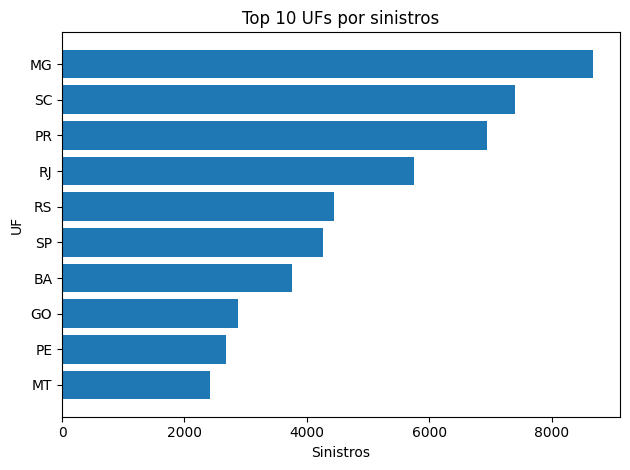

In [8]:
top = uf.head(10).sort_values("sinistros")
plt.figure()
plt.barh(top["uf"], top["sinistros"])
plt.title("Top 10 UFs por sinistros")
plt.xlabel("Sinistros")
plt.ylabel("UF")
plt.tight_layout()
plt.show()

## 4) Top Municípios (volume)

In [9]:
qry_mun = """
SELECT
  uf,
  municipio,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos
FROM silver.silver_sinistros
WHERE municipio IS NOT NULL AND municipio <> ''
GROUP BY uf, municipio
ORDER BY sinistros DESC
LIMIT 20;
"""
mun = pd.read_sql(qry_mun, engine)
mun

,uf,municipio,sinistros,mortos,feridos
0,DF,BRASILIA,926,43,995
1,RJ,DUQUE DE CAXIAS,755,24,868
2,SP,GUARULHOS,697,19,739
3,SC,SAO JOSE,678,12,760
4,PR,CURITIBA,637,28,653
5,MG,BETIM,618,18,717
6,ES,SERRA,529,19,624
7,PE,RECIFE,528,26,607
8,SC,PALHOCA,511,12,607
9,PB,JOAO PESSOA,498,17,588


## 5) Perfil temporal (dia da semana, fase do dia, hora)

In [10]:
qry_dow = """
SELECT
  dia_semana,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
GROUP BY dia_semana
ORDER BY sinistros DESC;
"""
dow = pd.read_sql(qry_dow, engine)
dow

,dia_semana,sinistros,mortos
0,SÁBADO,10554,1018
1,DOMINGO,10507,1080
2,SEXTA-FEIRA,10212,823
3,SEGUNDA-FEIRA,9189,660
4,QUINTA-FEIRA,8619,639
5,QUARTA-FEIRA,8555,644
6,TERÇA-FEIRA,8047,602


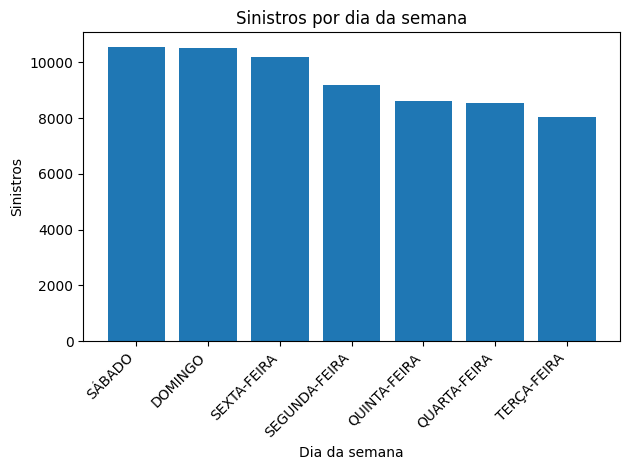

In [11]:
plt.figure()
plt.bar(dow["dia_semana"], dow["sinistros"])
plt.title("Sinistros por dia da semana")
plt.xlabel("Dia da semana")
plt.ylabel("Sinistros")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
qry_fase = """
SELECT
  fase_dia,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
GROUP BY fase_dia
ORDER BY sinistros DESC;
"""
fase = pd.read_sql(qry_fase, engine)
fase

,fase_dia,sinistros,mortos
0,PLENO DIA,36293,2148
1,PLENA NOITE,22623,2620
2,ANOITECER,3615,273
3,AMANHECER,3152,425


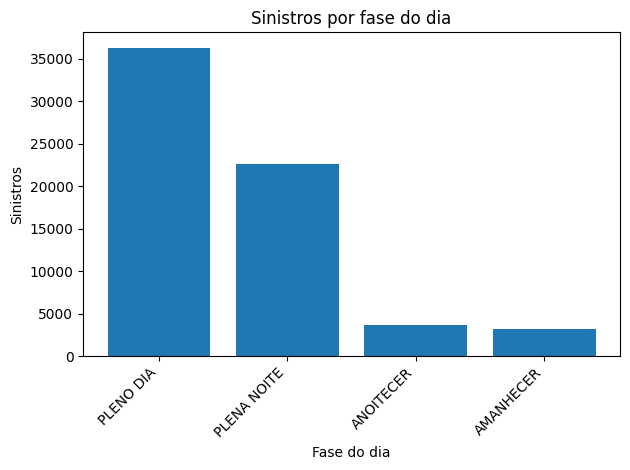

In [13]:
plt.figure()
plt.bar(fase["fase_dia"], fase["sinistros"])
plt.title("Sinistros por fase do dia")
plt.xlabel("Fase do dia")
plt.ylabel("Sinistros")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [14]:
qry_hora = """
SELECT
  EXTRACT(HOUR FROM hora_acidente)::int AS hora,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
WHERE hora_acidente IS NOT NULL
GROUP BY 1
ORDER BY 1;
"""
hora = pd.read_sql(qry_hora, engine)
hora.head()

,hora,sinistros,mortos
0,0,1334,171
1,1,1172,140
2,2,1031,144
3,3,1131,176
4,4,1444,221


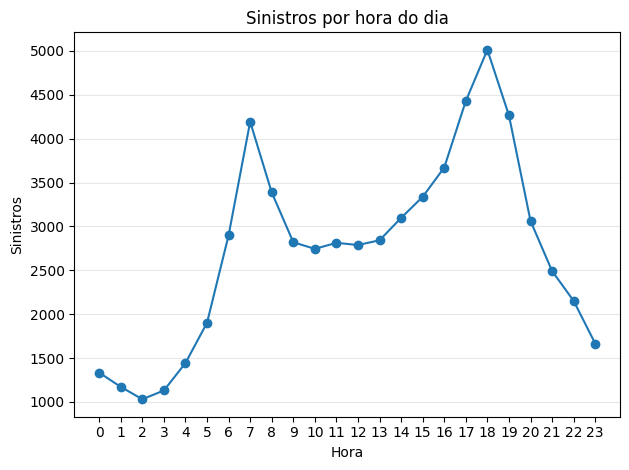

In [15]:
plt.figure()
plt.plot(hora["hora"], hora["sinistros"], marker="o")
plt.title("Sinistros por hora do dia")
plt.xlabel("Hora")
plt.ylabel("Sinistros")
plt.xticks(range(0,24))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 6) Tipos e causas (Top 15)

In [16]:
qry_tipo = """
SELECT
  tipo_acidente,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
WHERE tipo_acidente IS NOT NULL AND tipo_acidente <> ''
GROUP BY tipo_acidente
ORDER BY sinistros DESC
LIMIT 15;
"""
tipo = pd.read_sql(qry_tipo, engine)
tipo

,tipo_acidente,sinistros,mortos
0,COLISÃO TRASEIRA,13050,620
1,SAÍDA DE LEITO CARROÇÁVEL,9140,633
2,COLISÃO TRANSVERSAL,8541,442
3,COLISÃO LATERAL MESMO SENTIDO,7114,195
4,TOMBAMENTO,5747,269
5,COLISÃO COM OBJETO,4602,294
6,COLISÃO FRONTAL,4293,1670
7,QUEDA DE OCUPANTE DE VEÍCULO,3137,81
8,ATROPELAMENTO DE PEDESTRE,2774,841
9,COLISÃO LATERAL SENTIDO OPOSTO,1928,230


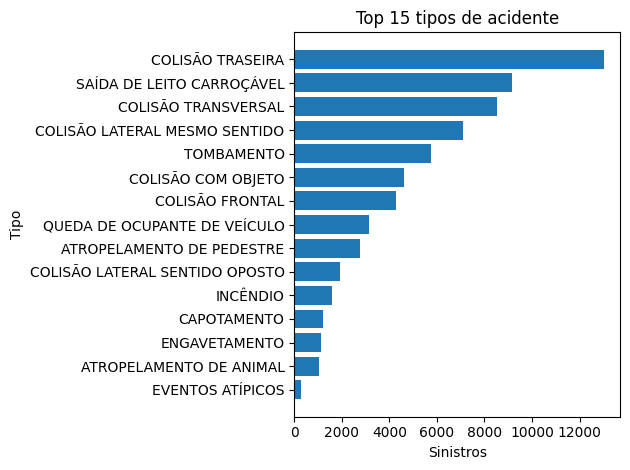

In [17]:
plt.figure()
plt.barh(tipo.sort_values("sinistros")["tipo_acidente"], tipo.sort_values("sinistros")["sinistros"])
plt.title("Top 15 tipos de acidente")
plt.xlabel("Sinistros")
plt.ylabel("Tipo")
plt.tight_layout()
plt.show()

In [18]:
qry_causa = """
SELECT
  causa_acidente,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos
FROM silver.silver_sinistros
WHERE causa_acidente IS NOT NULL AND causa_acidente <> ''
GROUP BY causa_acidente
ORDER BY sinistros DESC
LIMIT 15;
"""
causa = pd.read_sql(qry_causa, engine)
causa

,causa_acidente,sinistros,mortos
0,AUSÊNCIA DE REAÇÃO DO CONDUTOR,10322,761
1,REAÇÃO TARDIA OU INEFICIENTE DO CONDUTOR,9732,529
2,ACESSAR A VIA SEM OBSERVAR A PRESENÇA DOS OUTR...,6459,386
3,CONDUTOR DEIXOU DE MANTER DISTÂNCIA DO VEÍCULO...,4028,85
4,VELOCIDADE INCOMPATÍVEL,3683,439
5,MANOBRA DE MUDANÇA DE FAIXA,3657,165
6,INGESTÃO DE ÁLCOOL PELO CONDUTOR,3354,204
7,DEMAIS FALHAS MECÂNICAS OU ELÉTRICAS,3063,53
8,TRANSITAR NA CONTRAMÃO,2234,853
9,CONDUTOR DORMINDO,1916,161


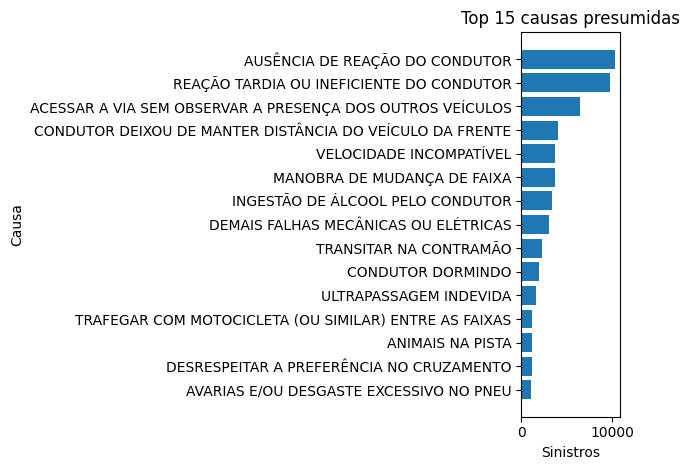

In [19]:
plt.figure()
plt.barh(causa.sort_values("sinistros")["causa_acidente"], causa.sort_values("sinistros")["sinistros"])
plt.title("Top 15 causas presumidas")
plt.xlabel("Sinistros")
plt.ylabel("Causa")
plt.tight_layout()
plt.show()

## 7) Urbano x Não urbano (comparação de severidade)

In [20]:
qry_urb = """
SELECT
  area_urbana,
  COUNT(*)::bigint AS sinistros,
  COALESCE(SUM(mortos),0)::bigint AS mortos,
  COALESCE(SUM(feridos),0)::bigint AS feridos,
  ROUND(COALESCE(SUM(mortos),0)::numeric / NULLIF(COUNT(*),0), 4) AS mortos_por_sinistro
FROM silver.silver_sinistros
GROUP BY area_urbana
ORDER BY sinistros DESC;
"""
urb = pd.read_sql(qry_urb, engine)
urb

,area_urbana,sinistros,mortos,feridos,mortos_por_sinistro
0,False,37323,4066,44081,0.1089
1,True,28360,1400,31297,0.0494


## 8) Hotspots (amostra de pontos geográficos)

> Sem biblioteca de mapas, usamos um scatter simples (lat/long). Para mapas interativos, recomenda-se Folium ou Kepler.gl.

In [21]:
qry_geo = """
SELECT latitude, longitude, mortos
FROM silver.silver_sinistros
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
LIMIT 20000;
"""
geo = pd.read_sql(qry_geo, engine)
geo.shape

(20000, 3)

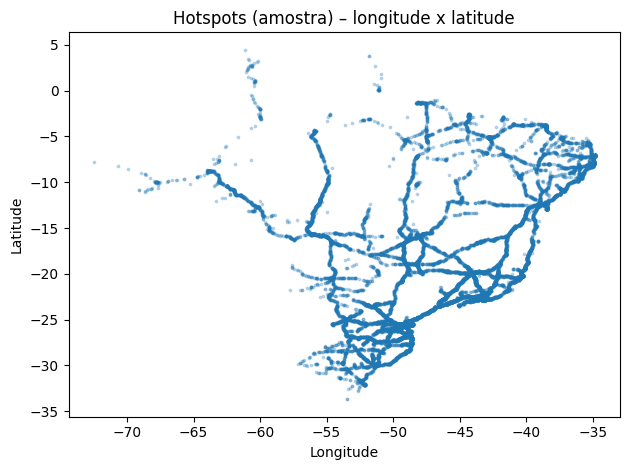

In [22]:
plt.figure()
plt.scatter(geo["longitude"], geo["latitude"], s=3, alpha=0.25)
plt.title("Hotspots (amostra) – longitude x latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

## 9) Views prontas para consumo (criadas no DDL)

- `silver.vw_sinistros_fatais`
- `silver.vw_sinistros_uf_stats`

Abaixo, um exemplo de consumo.

In [23]:
pd.read_sql("SELECT * FROM silver.vw_sinistros_uf_stats LIMIT 20;", engine)

,uf,total_acidentes,total_mortos,total_feridos,total_veiculos,inicio,fim
0,MG,8679,691,10782,17432,2025-01-01,2025-11-30
1,SC,7390,401,8474,14716,2025-01-01,2025-11-30
2,PR,6933,552,7725,14111,2025-01-01,2025-11-30
3,RJ,5749,304,6866,10624,2025-01-01,2025-11-30
4,RS,4434,286,4964,8628,2025-01-01,2025-11-30
5,SP,4264,189,4506,8439,2025-01-01,2025-11-30
6,BA,3759,529,4585,7971,2025-01-01,2025-11-30
7,GO,2869,260,3171,5775,2025-01-01,2025-11-30
8,PE,2686,309,2978,5216,2025-01-01,2025-11-30
9,MT,2415,231,2562,5665,2025-01-01,2025-11-30
